In [50]:
import torch
import torchvision.transforms.v2 as v2

In [4]:
from datasets import load_dataset

ds = load_dataset("zh-plus/tiny-imagenet")

Generating valid split: 100%|██████████| 10000/10000 [00:00<00:00, 605142.62 examples/s]


In [51]:
class MyDataset():
    def __init__(self, dataset, transform=None):
        super().__init__()
        self.dataset = dataset
        self.transform = transform
    
    def __getitem__(self, idx):
        x = self.dataset[idx]['image']
        y = self.dataset[idx]['label']
        if self.transform:
            x = self.transform(x)
        
        return x, y

    def __len__(self):
        return len(self.dataset)

In [62]:
IMG_MEAN = [0.485, 0.456, 0.406]
IMG_STD = [0.229, 0.224, 0.225]

data_transforms = {
    'train': v2.Compose([
        # transforms.RandomHorizontalFlip(),
        # transforms.RandomRotation(30),
        v2.ToImage(), 
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=IMG_MEAN, std=IMG_STD) # using full dataset values
    ]),
    'val': v2.Compose([
        v2.ToImage(), 
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=IMG_MEAN, std=IMG_STD) # using full dataset values
    ]),
    'test': v2.Compose([
        v2.ToImage(), 
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=IMG_MEAN, std=IMG_STD) # using full dataset values
    ])
}

In [63]:
from torch.utils.data import DataLoader

In [66]:
train_dataset = MyDataset(ds['train'], transform=data_transforms['train'])

train_subset, val_subset = torch.utils.data.random_split(train_dataset, [90000, 10000], generator=torch.Generator().manual_seed(1))

test_dataset = MyDataset(ds['valid'], transform=data_transforms['test'])

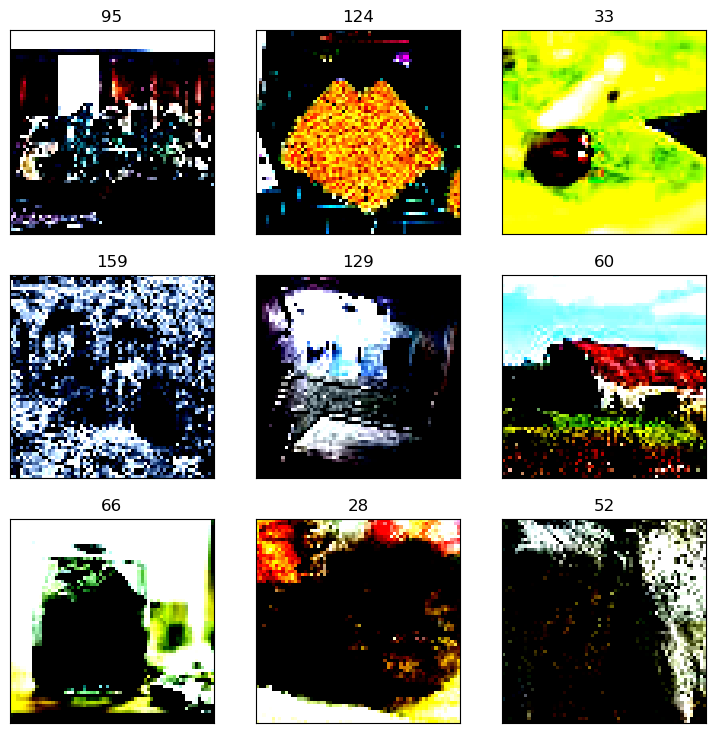

In [78]:
# visualize portion of training data:
import matplotlib.pyplot as plt
import random
%matplotlib inline

plt.figure(figsize=(9,9))

for i in range(9):
    idx = random.randint(0, len(train_dataset))
    img, label = train_dataset[idx]
    ax = plt.subplot(3, 3, i+1)
    ax.grid(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.title.set_text(label)

    ax.imshow(torch.clamp(img.view(3, 64, 64).permute(1, 2, 0), 0, 1))

In [67]:
BATCH_SIZE = 64
train_data_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
val_data_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)
test_data_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [80]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [337]:
# Embedding class
import math

class ImageEmbedding(nn.Module):
    """
        take square image of CxNxN pixels and create linear map of PxP patches to embedding dimension D
        Input: (B, C, N, N)
        Output: (B, C * P**2, D)
    """
    def __init__(self, img_size, patch_size, emb_size, num_channels, layer_norm_eps=1e-12, dropout=0.1):
        super().__init__()
        
        if img_size % patch_size != 0:
            raise Exception("image size must be divisible by patch size")
        
        self.img_size = img_size
        self.patch_size = patch_size
        self.emb_size = emb_size
        self.num_channels = num_channels

        max_seq_len = int(num_channels * patch_size**2)

        self.patch_embeddings = nn.Linear(max_seq_len, emb_size, bias=False)
        self.prepend_embedding = nn.Parameter(torch.randn(1, emb_size))
        self.positional_embeddings = nn.Linear(max_seq_len, emb_size, bias=False)

        self.ln = nn.LayerNorm(emb_size, eps=layer_norm_eps)
        self.dropout = nn.Dropout(dropout)

        self.register_buffer("position_ids", torch.arange(max_seq_len).expand((1, -1)).float())

    def forward(self, img):
        # patch input image (C, N, N) --> ((N/P)**2, P**2 * C)
        p = self.patch_size
        img = img.unfold(2, p, p).unfold(3, p, p).transpose(1, 3).reshape(-1, int(self.img_size/self.patch_size)**2, self.patch_size**2 * self.num_channels)
        emb = self.patch_embeddings(img)
        
        # prepend learnable embedding
        batch_size = img.shape[0]  
        prepend_embedding = self.prepend_embedding.expand(batch_size, -1)
        emb = torch.cat((prepend_embedding.unsqueeze(1), emb), dim=1)

        # add positional embedding
        emb = emb + self.positional_embeddings(self.position_ids)

        # add normalization and dropout
        emb = self.ln(emb)
        emb = self.dropout(emb)
        
        return emb

In [338]:
test = ImageEmbedding(4, 2, 10, 3)
x = torch.randn(3*4*4).view(1, 3, 4, 4).float()
x.dtype
out = test(x)
out, out.shape

(tensor([[[ 0.2921, -0.0608, -0.3524, -0.7573, -0.0000, -0.5113,  2.9379,
           -0.1624, -1.5551,  0.4068],
          [ 0.8224,  0.0143, -0.7317, -0.8456, -0.6588, -0.2284,  2.7565,
           -0.5874, -1.2305,  0.6893],
          [ 0.9047, -0.2559, -0.7733, -0.0000, -0.4537, -0.5021,  2.7642,
           -0.4840, -1.1959,  0.7399],
          [ 0.0000, -0.1533, -0.7139, -0.7615, -0.2853, -0.6354,  0.0000,
           -0.5158, -1.2052,  0.5652],
          [ 0.5554, -0.1959, -0.6756, -0.7555, -0.7188,  0.0727,  2.7220,
           -0.2837, -1.5223,  0.8017]]], grad_fn=<MulBackward0>),
 torch.Size([1, 5, 10]))